# NLTK 설치
### download가 안 되면 깃허브의 packages에 있는 걸 C:\nltk_data\tokenizers 로 download 해놓으면 된다
### https://github.com/nltk/nltk_data/tree/gh-pages/packages

In [1]:
import nltk

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

    [nltk_data] Downloading package punkt to
    [nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
    [nltk_data]   Unzipping tokenizers\punkt.zip.
로 출력되었다

In [2]:
sentence = '''At eight o'clock on Thursday morning Arthur didn't feel very good.'''

In [3]:
tokens = nltk.word_tokenize(sentence)
tokens

['At',
 'eight',
 "o'clock",
 'on',
 'Thursday',
 'morning',
 'Arthur',
 'did',
 "n't",
 'feel',
 'very',
 'good',
 '.']

In [4]:
tagged = nltk.pos_tag(tokens)
tagged

[('At', 'IN'),
 ('eight', 'CD'),
 ("o'clock", 'NN'),
 ('on', 'IN'),
 ('Thursday', 'NNP'),
 ('morning', 'NN'),
 ('Arthur', 'NNP'),
 ('did', 'VBD'),
 ("n't", 'RB'),
 ('feel', 'VB'),
 ('very', 'RB'),
 ('good', 'JJ'),
 ('.', '.')]

# 튜토리얼
- NLP(자연어 처리)
- IMDB 영화 리뷰를 로딩하고 정제하고 간단한 BOW(Bag of Words) 모델을 적용하여 리뷰가 추천인지 아닌지에 대한 정확도를 예측

In [5]:
import pandas as pd
'''
header = 0 은 파일의 첫 번째 줄에 열 이름이 있음을 나타내며
delimiter = \t 는 필드가 탭으로 구분되는 것을 의미한다.
quoting = 3은 큰따옴표를 무시하도록 한다.
'''

# 레이블인 sentiment가 있는 학습 데이터
train = pd.read_csv('word_tutorial/labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)

# 레이블이 없는 테스트 데이터
test = pd.read_csv('word_tutorial/testData.tsv', header=0, delimiter='\t', quoting=3)

train.shape

(25000, 3)

In [6]:
train.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


In [7]:
test.tail(3)

,id,review
24997,"""2531_1""","""I was so disappointed in this movie. I am ver..."
24998,"""7772_8""","""From the opening sequence, filled with black ..."
24999,"""11465_10""","""This is a great horror film for people who do..."


In [8]:
# test에는 sentiment 레이블이 없어 기계학습으로 예측
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [9]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [10]:
train['sentiment'].value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [11]:
# html 태그가 섞여 있기 때문에 이를 정제해줄 필요가 있음
train['review'][0][:700]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik'

### NLP 텍스트 데이터 전처리
## 데이터 정제 Data Cleaning and Text Preprocessing
기계가 텍스트를 이용하라 수 있도록 텍스트를 정제
- BeautifulSoup(뷰티풀숩)을 통해 HTML 태그를 제거
- 정규표현식으로 알파벳 이외의 문자를 공백으로 치환
- NLTK 데이터를 사용해 불용어(Stopword)를 제거
- 어간추출(스테밍 Stemming)과 음소표기법(Lemmatizing)의 개념을 이해하고 SnowballStemmer를 통해 어간을 추출

### 정규화 normalization (입니닼ㅋㅋ -> 입니다 ㅋㅋ, 샤릉해 -> 사랑해)
- 한국어를 처리하는 예시입니닼ㅋㅋㅋㅋㅋ -> 한국어를 처리하는 예시입니다 ㅋㅋ

### 토큰화 tokenization
- 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하는Verb, 예시Noun, 입Adjective, 니다Eomi ㅋㅋKoreanParticle

### 어근화 stemming (입니다 -> 이다)
- 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어Noun, 를Josa, 처리Noun, 하다Verb, 예시Noun, 이다Adjective, ㅋㅋKoreanParticle

### 어구 추출 phrase extraction
- 한국어를 처리하는 예시입니다 ㅋㅋ -> 한국어, 처리, 예시, 처리하는 예시

In [12]:
from bs4 import BeautifulSoup
import lxml

#example1 = BeautifulSoup(train['review'][0], "html.parser")
example1 = BeautifulSoup(train['review'][0], "lxml")
print(train['review'][0][:700])
print(example1.get_text()[:700])

# html.parser 말고 pip install lxml 한 다음에 lxml을 써도 된다

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely lik
"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe 

In [13]:
# 정규 표현식으로 특수문자 제거 (공백으로 만든다)

import re
letters_only = re.sub('[^a-zA-Z]', ' ', example1.get_text())
letters_only[:700]

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyw'

In [14]:
# 소문자로 변환
lower_case = letters_only.lower()
# 문자를 나눔 -> 토큰화
words = lower_case.split()
print(len(words))
words[:10]

437


['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

In [15]:
# 불용어 제거

import nltk
from nltk.corpus import stopwords

stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [32]:
# 다운로드
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [16]:
# 불용어를 제거한 토큰들
words = [w for w in words if not w in stopwords.words('english')]
print(len(words))
words[:10]

219


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [17]:
# 포터 스테머 사용
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('maximum'))
print('The stemmed form of running is: {}'.format(stemmer.stem('running')))
print('The stemmed form of runs is: {}'.format(stemmer.stem('runs')))
print('The stemmed form of run is: {}'.format(stemmer.stem('run')))

maximum
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [18]:
# 랭커스터 스테머 사용
from nltk.stem.lancaster import LancasterStemmer

lancaster_stemmer = LancasterStemmer()
print(lancaster_stemmer.stem('maximum'))
print('The stemmed form of running is: {}'.format(lancaster_stemmer.stem('running')))
print('The stemmed form of runs is: {}'.format(lancaster_stemmer.stem('runs')))
print('The stemmed form of run is: {}'.format(lancaster_stemmer.stem('run')))

maxim
The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


In [19]:
# 스노우볼 스테머
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

In [20]:
# 처리전
print(words[:10])
# 처리후
words = [stemmer.stem(w) for w in words]
print(words[:10])

['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music', 'watching', 'odd', 'documentary']
['stuff', 'go', 'moment', 'mj', 'start', 'listen', 'music', 'watch', 'odd', 'documentari']


In [40]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [21]:
# 레마타이제이션, Lemmatization (음소표기법)
# 앞뒤 문맥을 보고 단어의 의미를 식별

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

print(wordnet_lemmatizer.lemmatize('fly'))
print(wordnet_lemmatizer.lemmatize('flies'))

# 처리 전
print(words[:10])

# 처리 후
words = [wordnet_lemmatizer.lemmatize(w) for w in words]
print(words[:10])

fly
fly
['stuff', 'go', 'moment', 'mj', 'start', 'listen', 'music', 'watch', 'odd', 'documentari']
['stuff', 'go', 'moment', 'mj', 'start', 'listen', 'music', 'watch', 'odd', 'documentari']


### 위의 내용들을 합쳐 문자열을 처리

In [22]:
def review_to_words(raw_review):
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    words = letters_only.lower().split()
    # 파이썬은 리스트보다 세트에서 찾는게 빨라 타입을 변환
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    # 어간 추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 공백으로 구분된 문자열로 결합하여 결과 반환
    return(' '.join(stemming_words))

In [23]:
clean_review = review_to_words(train['review'][0])
clean_review

'stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl stay

In [36]:
'''
clean_train_reviews = []

# for i in range(0, num_reviews):
#     clean_train_reviews.append( review_to_words(train['review'][i]))

코드를 간결하게 하기 위해 apply 사용(시간도 출력)
# %time train['review_clean'] = train['review'].apply(review_to_words)
'''
num_reviews = train['review'].size
clean_train_reviews = []

for i in range(0, num_reviews):
    clean_train_reviews.append( review_to_words(train['review'][i]))

In [37]:
clean_train_reviews[:2]

['stuff go moment mj start listen music watch odd documentari watch wiz watch moonwalk mayb want get certain insight guy thought realli cool eighti mayb make mind whether guilti innoc moonwalk part biographi part featur film rememb go see cinema origin releas subtl messag mj feel toward press also obvious messag drug bad kay visual impress cours michael jackson unless remot like mj anyway go hate find bore may call mj egotist consent make movi mj fan would say made fan true realli nice actual featur film bit final start minut exclud smooth crimin sequenc joe pesci convinc psychopath power drug lord want mj dead bad beyond mj overheard plan nah joe pesci charact rant want peopl know suppli drug etc dunno mayb hate mj music lot cool thing like mj turn car robot whole speed demon sequenc also director must patienc saint came film kiddi bad sequenc usual director hate work one kid let alon whole bunch perform complex danc scene bottom line movi peopl like mj one level anoth think peopl sta

In [20]:
# worker들을 여러 개 나누어서 한 번에 처리
# 참고 : https://gist.github.com/yong27/7869662
# NLP에 대해 worker 분리하여 처리하는 법
# http://www.racketracer.com/2016/07/06/pandas-in-parallel/

from multiprocessing import Pool
import numpy as np

def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
    # 키워드 항목 중 workers 파라메터를 꺼냄
    workers = kwargs.pop('workers')
    # 위에서 가져온 workers 수로 프로세스 풀을 정의
    pool = Pool(processes=workers)
    # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
    result = pool.map(_apply_df, [(d, func, kwargs)
            for d in np.array_split(df, workers)])
    pool.close()
    # 작업 결과를 합쳐서 반환
    return pd.concat(list(result))

In [ ]:
# worker를 사용하는게 현재 노트북에서 돌아가지 않는다
%time clean_train_reviews = apply_by_multiprocessing(\
    train['review'], review_to_words, workers=4)

## 워드클라우드
- 단어 빈도수 데이터로 시각화 (큰 정보 얻기는 힘들다)

In [24]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

def displayWordcloud(data = None, backgroundcolor = 'white', width=600, height=400):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                         background_color=backgroundcolor,
                         width=width, height=height).generate(data)
    
    plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

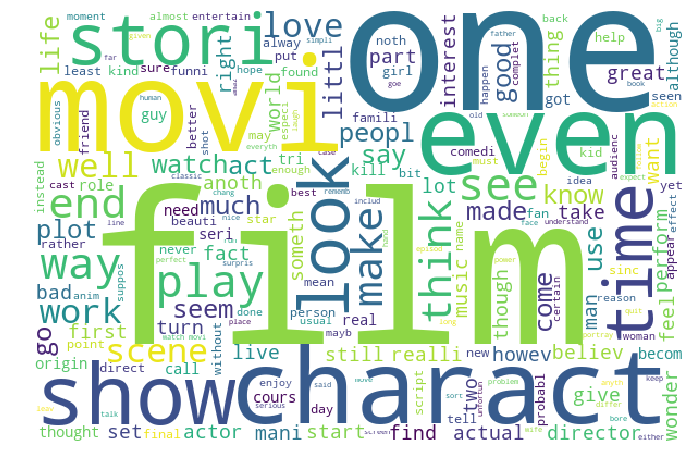

Wall time: 14.4 s


In [29]:
# 학습 데이터의 모든 단어에 대한 워드 클라우드
%time displayWordcloud(' '.join(clean_train_reviews))

In [60]:
# Series의 map은 DataFrame의 apply와 비슷하다
clean_train_reviews_se = pd.Series(clean_train_reviews)
clean_train_reviews_se.head()

0    stuff go moment mj start listen music watch od...
1    classic war world timothi hine entertain film ...
2    film start manag nichola bell give welcom inve...
3    must assum prais film greatest film opera ever...
4    superbl trashi wondrous unpretenti exploit hoo...
dtype: object

In [61]:
# 단어 수
train['num_words'] = clean_train_reviews_se.map(lambda x: len(str(x).split()))
# 중복을 제거한 단어 수
train['num_uniq_words'] = clean_train_reviews_se.map(lambda x: len(set(str(x).split())))

In [62]:
train.head()

,id,sentiment,review,num_words,num_uniq_words
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",219,156
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",84,63
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",240,201
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",189,158
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",210,188


In [63]:
# 첫 번째 리뷰
x = clean_train_reviews[0]
x = str(x).split()
print(len(x))
x[:10]

219


['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari']

In [64]:
print(len(x))
print(len(set(x)))

219
156


Malgun Gothic
리뷰 별 단어 평균값 : 119.52356
리뷰 별 단어 중간값 89.0
리뷰 별 고유 단어 평균값 : 94.05756
리뷰 별 고유 단어 중간값 74.0


Text(0.5, 1.0, '리뷰 별 고유 단어 수 분포')

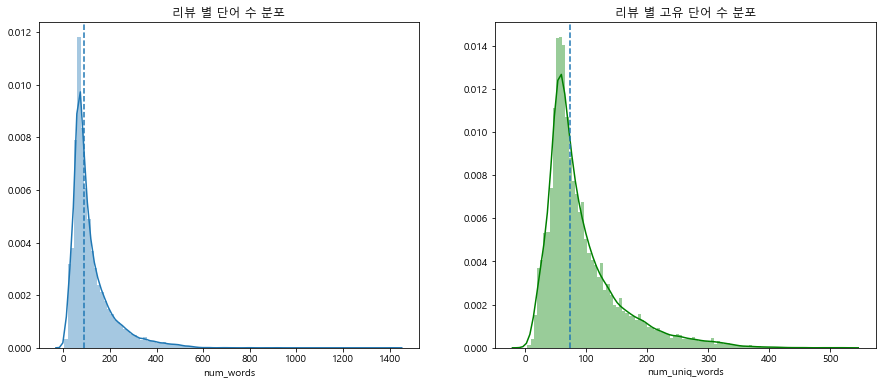

In [69]:
import seaborn as sns
import matplotlib.font_manager as fm

path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=30).get_name()
print(font_name)
plt.rc('font', family=font_name)

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(15,6)

print('리뷰 별 단어 평균값 :', train['num_words'].mean())
print('리뷰 별 단어 중간값', train['num_words'].median())
sns.distplot(train['num_words'], bins=100, ax=axes[0])
axes[0].axvline(train['num_words'].median(), linestyle='dashed')
axes[0].set_title('리뷰 별 단어 수 분포')

print('리뷰 별 고유 단어 평균값 :', train['num_uniq_words'].mean())
print('리뷰 별 고유 단어 중간값', train['num_uniq_words'].median())
sns.distplot(train['num_uniq_words'], bins=100, ax=axes[1], color='g')
axes[1].axvline(train['num_uniq_words'].median(), linestyle='dashed')
axes[1].set_title('리뷰 별 고유 단어 수 분포')

# Bag of words 내용 이해 후 진행
# 사이킷런의 CountVectorizer를 통해 feature 생성
- 정규 표현식을 사용하여 토큰을 추출, 모두 소문자로 변환
- 의미 없는 특성 많이 생성되므로 적어도 2개 문서에 나타난 토큰만 사용
- min_df로 토큰이 나타날 최소 문서 개수 지정 가능

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer='word',
                            tokenizer=None,
                            preprocessor=None,
                            stop_words=None,
                            min_df=2, # 토큰이 나타날 최소 문서 개수
                            ngram_range=(1,3),
                            max_features=20000)
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [71]:
# 속도 개선하기 위해 파이프라인 사용
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [72]:
train_data_features = pipeline.fit_transform(clean_train_reviews)
train_data_features

<25000x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 2762268 stored elements in Compressed Sparse Row format>

In [73]:
train_data_features.shape

(25000, 20000)

In [74]:
vocab = vectorizer.get_feature_names()
vocab[:10]

['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [75]:
# 벡터화된 feature 확인
import numpy as np
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)
    
pd.DataFrame(dist, columns=vocab)

[[26 48 22 ... 59 40 23]] aag


,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,...,23,52,37,89,161,31,71,59,40,23


In [76]:
pd.DataFrame(train_data_features[:100].toarray(), columns=vocab).head()

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 랜덤 포레스트로 영화감성예측평가 ROC/AUC
- positive인지 negative인지
    - 분류이므로 지도 학습

In [78]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤 포레스트 분류기 사용
# n_jobs는 cpu코어 사용 개수(-1이면 모두 사용)
# 같은 state 지정 위해 random_state 사용
forest = RandomForestClassifier(
    n_estimators=100, n_jobs= -1, random_state=2018
)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [79]:
%time forest = forest.fit(train_data_features, train['sentiment'])

Wall time: 6.45 s


In [81]:
# 영상 강의노트와 from부분이 다르다
# roc곡선 사용 위해 scoring에 roc_auc 넣음
from sklearn.model_selection import cross_val_score
%time np.mean(cross_val_score(forest, train_data_features, train['sentiment'], cv=10, scoring='roc_auc'))

Wall time: 58.1 s


0.92761104

In [83]:
num_reviews2 = test['review'].size
clean_test_reviews = []

for i in range(0, num_reviews2):
    clean_test_reviews.append( review_to_words(test['review'][i]))

In [84]:
# 정제한 리뷰의 첫 번째 데이터 확인
clean_test_reviews[0]

'natur film main theme mortal nostalgia loss innoc perhap surpris rate high older viewer younger one howev craftsmanship complet film anyon enjoy pace steadi constant charact full engag relationship interact natur show need flood tear show emot scream show fear shout show disput violenc show anger natur joyc short stori lend film readi made structur perfect polish diamond small chang huston make inclus poem fit neat truli masterpiec tact subtleti overwhelm beauti'

In [85]:
# 테스트 데이터를 벡터화
%time test_data_features = pipeline.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

Wall time: 5.73 s


In [86]:
test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [87]:
# 벡터화된 단어로 숫자가 문서에서 등장하는 횟수를 나타낸다
test_data_features[5][:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [88]:
# 벡터화하며 만든 사전에서 해당 단어가 무엇인지 찾아볼 수 있다.
# vocab = vectorizer.get_feature_names()
vocab[8], vocab[2558], vocab[2559], vocab[2560]

('abc', 'charact person', 'charact play', 'charact plot')

In [89]:
# 테스트 데이터를 넣고 예측
result = forest.predict(test_data_features)
result[:10]

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0], dtype=int64)

In [90]:
# 예측 결과를 데이터프레임에 저장
output = pd.DataFrame(data={'id':test['id'], 'sentiment':result})
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",0
3,"""7186_2""",1
4,"""12128_7""",1


In [ ]:
#  csv로 저장, index는 저장하지 않음
output.to_csv('data/tutorial_1_BOW_model.csv', index=False, quoting=3)

In [91]:
output_sentiment = output['sentiment'].value_counts()
print(output_sentiment[0]-output_sentiment[1])
output_sentiment

108


0    12554
1    12446
Name: sentiment, dtype: int64

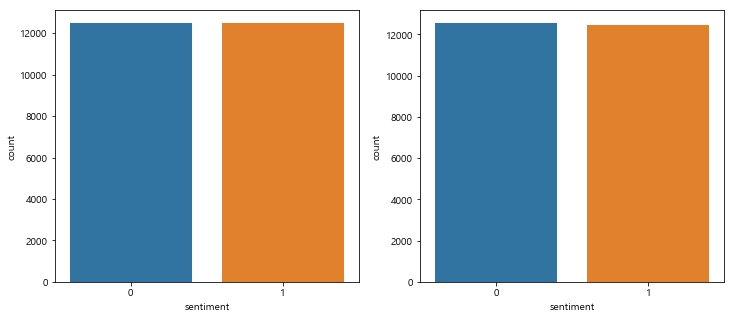

In [92]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.countplot(train['sentiment'], ax=axes[0])
sns.countplot(output['sentiment'], ax=axes[1])

### train에는 0과 1의 수가 같았지만 예측은 조금 달랐다